In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [ ]:
data_dir = '/content/drive/My Drive/Drexel/MEM679/chest_xray'

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

dataset = load_dataset('imagefolder', data_dir=data_dir,
                       split={'test': 'test'})

Resolving data files:   0%|          | 0/5216 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/624 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Image with feature map

Output structure: <class 'tuple'> 2
Feature map: [(tensor([[[-0.9159,  1.1535,  0.1155,  ...,  2.7596, -1.2252,  3.2118],
         [-0.3285,  0.3014,  0.6747,  ...,  0.7961, -1.8793,  2.6243],
         [-0.3639,  0.0135,  0.5282,  ...,  0.7714, -1.9116,  2.6470],
         ...,
         [-0.8881,  0.7049,  0.1908,  ...,  2.5020, -1.3327,  2.9846],
         [-0.8841,  0.7939,  0.1451,  ...,  2.5152, -1.3901,  2.9491],
         [-0.6639,  0.7074,  0.4442,  ...,  0.9673, -2.0058,  2.6970]]],
       grad_fn=<ViewBackward0>), None)]


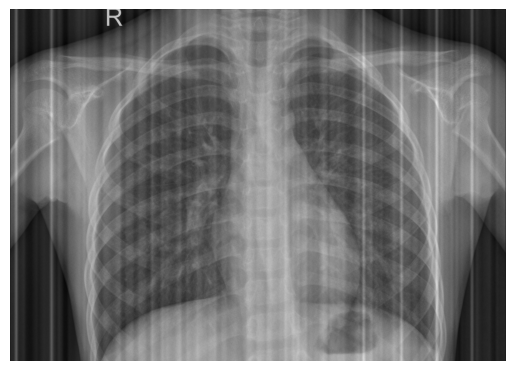

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoModelForImageClassification, AutoImageProcessor
import cv2

# Load model and processor
model_name = "Towen/vit-base-patch16-224-in21k-finetuned"
model = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

# Load and preprocess image
img_path = dataset['test'][0]['image']
img = img_path.convert("RGB")

# Preprocess the image for the model
inputs = processor(images=img, return_tensors="pt")

# Modify register_hooks to access the correct layer
def register_hooks(model):
    def hook_fn(module, input, output):
        print("Output structure:", type(output), len(output) if isinstance(output, (tuple, list)) else None)
        feature_map.append(output)  # Try appending the entire output for inspection

    feature_map = []
    # Access the last attention layer within the ViT architecture
    model.vit.encoder.layer[-1].attention.attention.register_forward_hook(hook_fn)
    return feature_map

# Register hook and get feature maps
feature_map = register_hooks(model)

# Forward pass
# Pass output_hidden_states=True to get hidden states
with torch.enable_grad():
    outputs = model(**inputs, output_hidden_states=True)

# Inspect the feature_map to understand the output structure
print("Feature map:", feature_map)

# Get the last layer feature map (the attention map)
# Access the attention weights from the feature_map list
grads = feature_map[0][0].detach().cpu().numpy()

# Average the gradients across the attention heads
grads = grads.mean(axis=1).squeeze()  # Shape (num_patches, num_patches)

# Get the output of the last attention layer (the feature map)
feature_map = outputs.hidden_states[-2].detach().cpu().numpy()

# Create a heatmap by combining the feature map and gradients
heatmap = np.dot(feature_map.reshape(feature_map.shape[0] * feature_map.shape[1], feature_map.shape[2]), grads)
heatmap = np.maximum(heatmap, 0)  # Remove negative values
heatmap = heatmap.reshape(feature_map.shape[0], feature_map.shape[1]) # Reshape heatmap
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))  # Resize heatmap to image size

# Normalize the heatmap
heatmap = heatmap / np.max(heatmap)

# Create an overlay by applying the heatmap to the image
heatmap_img = np.uint8(255 * heatmap)  # Convert heatmap to an image
heatmap_img = np.expand_dims(heatmap_img, axis=-1)  # Add a channel dimension
heatmap_img = np.repeat(heatmap_img, 3, axis=-1)  # Convert heatmap to 3 channels
overlay_img = 0.7 * np.array(img) + 0.3 * heatmap_img  # Overlay heatmap on original image

# Plot the heatmap using the chosen colormap
plt.imshow(overlay_img.astype(np.uint8))
plt.axis('off')  # Hide axes
plt.show()

# Grad-CAM

In [ ]:
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=f5e6526a842fe4a74b9f025aa1a7ba0d59c655608f30ba8a8bc4197338499803
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoModelForImageClassification, AutoImageProcessor
import cv2
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

image = dataset['test'][520]
processor = AutoImageProcessor.from_pretrained("Towen/vit-base-patch16-224-in21k-finetuned")
model = AutoModelForImageClassification.from_pretrained("Towen/vit-base-patch16-224-in21k-finetuned")
# prepare image for the model
encoding = processor(image['image'].convert("RGB"), return_tensors="pt")

# Get the target layer for Grad-CAM
target_layer = model.vit.encoder.layer[-1].attention.attention
# Create a GradCAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# forward pass, and calculate targets within the forward pass
with torch.no_grad():
    outputs = model(**encoding)
    predicted_class = outputs.logits.argmax().item()
    targets = [ClassifierOutputTarget(predicted_class)]
    # Pass the pixel values as input tensor
    grayscale_cam = cam(input_tensor=encoding.pixel_values, targets=targets)

# Convert the grayscale heatmap to RGB
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(np.array(image['image'].convert("RGB")) / 255., grayscale_cam, use_rgb=True)

# Plot the result
plt.imshow(visualization)
plt.axis('off')  # Hide axes
plt.show()

AttributeError: 'ViTSdpaSelfAttention' object has no attribute 'proj'

In [ ]:
incorrect_predictions

[{'index': 16,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1300x617>,
  'predicted_label': 1,
  'true_label': 0},
 {'index': 67,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1542x871>,
  'predicted_label': 1,
  'true_label': 0},
 {'index': 120,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1720x1568>,
  'predicted_label': 1,
  'true_label': 0},
 {'index': 121,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1960x1688>,
  'predicted_label': 1,
  'true_label': 0},
 {'index': 122,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1584x1168>,
  'predicted_label': 1,
  'true_label': 0},
 {'index': 123,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1800x1456>,
  'predicted_label': 1,
  'true_label': 0},
 {'index': 124,
  'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1536x1064>,
  'predicted_label': 1,
  'true_label': 0},
 {'index': 126,
  'image': <PIL.JpegImagePlugin.Jpeg